# Initial implementation of PIICM

Will make a stab at implementing the original version of PIICM in the newest version of gpytorch. There are a few ingredients that are needed

1. The kernel  -- we need to construct a permutation invariant covariance function.
    1. Needs to return objects with custom .matmul routines, custom log_det calculations etc. This was done in the original implementation by extending the `LazyTensor` class, which is no longer available. Will need to work with the `LinearOperators` instead, but hopefully should be rather straight-forward.
2. The likelihood -- we need a multi-task normal likelihood that allows us to add a observation specific noise term
3. Model -- putting these two together and maximizing the marginal likelihood using CG for the inverse solve and a custom log-determinant calculation involving Weyl's inequality.

It needs to all play nice with the current classes, extending were needed but otherwise not interferring with gpytorch.

## Framework of LinearOperators

Have constructed three new classes, extending the `LinearOperator` class.
 1. `GPattKroneckerProductLinearOperator` simple extension of `KroneckerProductLinearOperator`
 2. `GPattKroneckerSumLinearOperator`, the result of `GPattKroneckerProductLinearOperator`+`GPattKroneckerProductLinearOperator`, essentially the prior of the PIICM
 3. `GPattKroneckerSumAddedDiagLinearOperator`, the result of `GPattKroneckerSumLinearOperator`+`DiagLinearOperator` -- for when the likelihood is added
 
Can verify that these do what they are supposed to below 

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import torch
from linear_operator.operators import DenseLinearOperator, KroneckerProductLinearOperator, DiagLinearOperator
from synpred.linear_operator.operators.gpatt_kronecker_product_linear_operator import GPattKroneckerProductLinearOperator

# Generate two tensors
a = torch.tensor([[4, 0, 2], [0, 3, -1], [2, -1, 3]], dtype=torch.float)
b = torch.tensor([[2, 1], [1, 2]], dtype=torch.float)

# The Kronecker product
c = KroneckerProductLinearOperator(DenseLinearOperator(a),DenseLinearOperator(b))

# Wrap it as a GPattKroneckerProduct
d = GPattKroneckerProductLinearOperator(c)
print(d)

# Summing two GPattKroneckerProducts
e = d + d
print(e)

# Adding a diagonal
diag = DiagLinearOperator(e.diagonal())
f = e + diag
print(f)


## The likelihood

I need to make a version of the `FixedNoiseMultitaskGaussianLikelihood` which should be relatively straight forward

In [ ]:
from synpred.likelihoods.fixed_noise_multitask_gaussian_likelihood import FixedNoiseMultitaskGaussianLikelihood
noise = 0.1 + torch.rand(4)
lik = FixedNoiseMultitaskGaussianLikelihood(num_tasks=4,noise=noise)
lik.noise_covar

## The kernel
Should also have been set up correctly now, we can check some things

## Simulated data

In [2]:
# Some initial imports needed to set up everything
import math
import torch
import gpytorch
import synpred
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import pyplot as plt
print(gpytorch.__version__)
print(torch.__version__)
# Is this wrong?
%load_ext autoreload
%autoreload 2

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
1.11
2.1.1


In [3]:
torch.random.manual_seed(2762)
N = 121
N_D = 7
N_C = 5
N_T = N_D*N_C
N_total = N*N_D*N_C

# Output covariance
X = torch.tensor(np.mgrid[0:1:11j, 0:1:11j].reshape(2, -1).T).float()
K_X = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
K_X.base_kernel.lengthscale = 0.75
K_X.outputscale = 0.5
K_X = K_X(X).evaluate() + 1e-4*torch.eye(N)
# Task covariance
# Drug
d_rank = 3
B = torch.randn(N_D,d_rank)
v = torch.randn(N_D)**2
K_D = B.matmul(B.t()) + torch.diag(v)
# Cell
c_rank = 2
B = torch.randn(N_C,c_rank)
v = torch.randn(N_C)**2
K_C = B.matmul(B.t()) + torch.diag(v)
# Task
K_T = torch.kron(K_C,K_D)
# Total
K = torch.kron(K_T,K_X)
# Add some noise
nugget = 1e-3
K = K + torch.eye(N_total)*nugget

In [4]:
# Create instance of MVN
m = torch.distributions.MultivariateNormal(torch.zeros(N_total), K)
y = m.sample()
Y = torch.zeros((N,N_T))
for i in range(N_T):
    Y[:,i] = y[i*N:(i*N+N)]
y = Y + 0.0001*torch.randn(Y.shape)
s = torch.zeros(y.shape)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


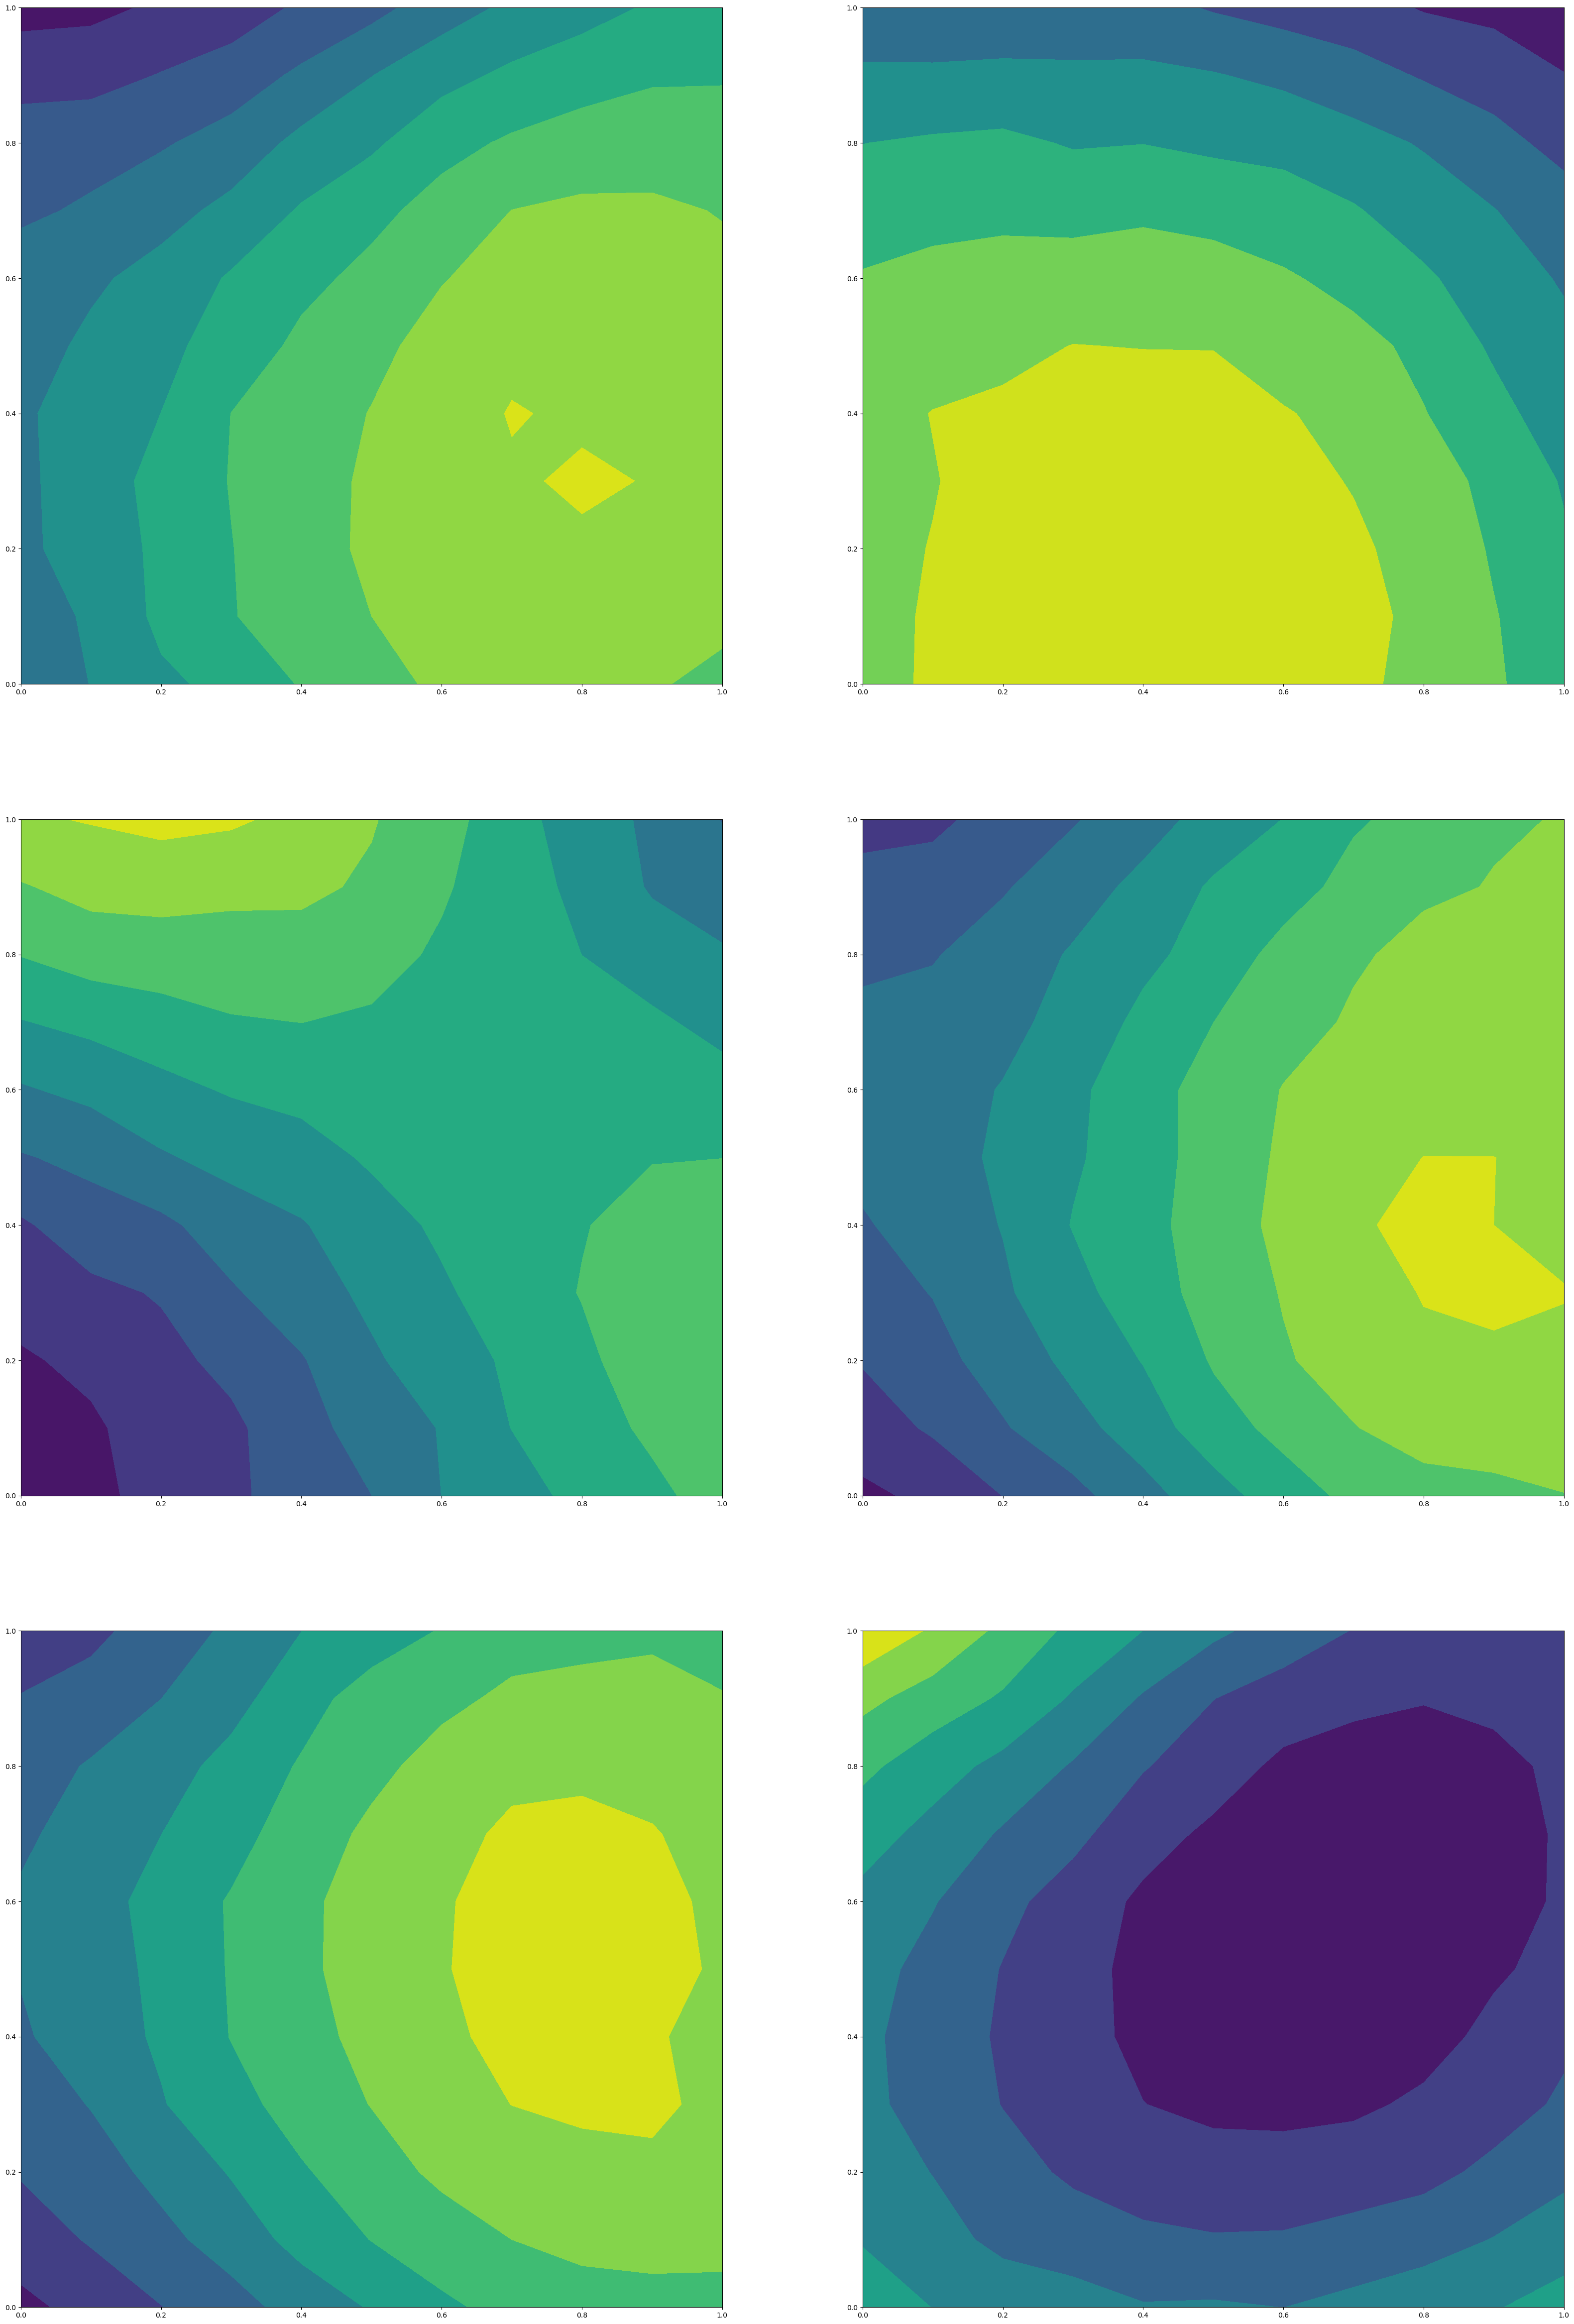

In [5]:
# Plot
[Xt,Yt] = np.meshgrid(X[:,0].unique().numpy(),X[:,1].unique().numpy())
%matplotlib inline
f, ((y1_ax, y2_ax), (y3_ax, y4_ax), (y5_ax, y6_ax)) = plt.subplots(3, 2, figsize=(40, 60))
y1_ax.contourf(Xt,Yt,y[:,0].reshape(Xt.shape).detach().numpy(),cmap='viridis')
y2_ax.contourf(Xt,Yt,y[:,3].reshape(Xt.shape).detach().numpy(),cmap='viridis')
y3_ax.contourf(Xt,Yt,y[:,1].reshape(Xt.shape).detach().numpy(),cmap='viridis')
y4_ax.contourf(Xt,Yt,y[:,4].reshape(Xt.shape).detach().numpy(),cmap='viridis')
y5_ax.contourf(Xt,Yt,y[:,2].reshape(Xt.shape).detach().numpy(),cmap='viridis')
y6_ax.contourf(Xt,Yt,y[:,5].reshape(Xt.shape).detach().numpy(),cmap='viridis')
None

In [6]:
# If we are in the symmetric setting, expand the input dimension
symmetric = True
if symmetric:
    n, p = y.shape
    p = 2*p
    tmp = torch.full([n,p],float('nan'))
    tmp_noise = torch.full([n,p],float('nan'))
    for i in range(N_C):
        orig = y[:,(i*N_D):(i*N_D+N_D)]
        orig_noise = s[:,(i*N_D):(i*N_D+N_D)]
        new = torch.full(orig.shape,float('nan'))
        new_noise = torch.full(orig.shape,float('nan'))
        combined = torch.cat([orig,new],-1)
        combined_noise = torch.cat([orig_noise,new_noise],-1)
        tmp[:,(i*(2*N_D)):(i*(2*N_D)+2*N_D)] = combined
        tmp_noise[:,(i*(2*N_D)):(i*(2*N_D)+2*N_D)] = combined_noise
    y = tmp
    s = tmp_noise

In [7]:
# Fill in missing values with dummy variables and mask
# Pad with missing values and large noise
mVAL = -999
mVAR = 99999999999999
missing_idx = y.isnan()
N_missing = missing_idx.sum()
# Train output is given a fixed dummy values
y = y.masked_fill(missing_idx,mVAL)
# Correspondingly these are given a large noise
s = s.masked_fill(missing_idx,mVAR)

In [8]:
# Define some constants
if symmetric:
    N_tasks = 2*N_T
else:
    N_tasks = N_T
N_total = y.numel()
N_obs = int(N_total-N_missing)

In [9]:
y

tensor([[ 5.5824e-01, -7.4135e+00,  1.4012e+00,  ..., -9.9900e+02,
         -9.9900e+02, -9.9900e+02],
        [ 1.0145e+00, -7.3223e+00,  1.8704e+00,  ..., -9.9900e+02,
         -9.9900e+02, -9.9900e+02],
        [ 1.4153e+00, -7.0293e+00,  2.3801e+00,  ..., -9.9900e+02,
         -9.9900e+02, -9.9900e+02],
        ...,
        [ 1.3279e+00, -4.4784e+00,  5.3863e+00,  ..., -9.9900e+02,
         -9.9900e+02, -9.9900e+02],
        [ 1.5508e+00, -4.9222e+00,  5.4645e+00,  ..., -9.9900e+02,
         -9.9900e+02, -9.9900e+02],
        [ 1.5645e+00, -5.6281e+00,  5.3589e+00,  ..., -9.9900e+02,
         -9.9900e+02, -9.9900e+02]])

In [10]:
from synpred.likelihoods.fixed_noise_multitask_gaussian_likelihood import FixedNoiseMultitaskGaussianLikelihood
from synpred.kernels.piicm import PIICM

In [11]:
# Here now set up the model
class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ZeroMean(), num_tasks=N_tasks
        )
        self.covar_module = PIICM(
            gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()), 
            num_combinations = N_D, num_cell_lines=N_C,  
            drug_rank=2*d_rank, cell_linerank = c_rank,
            symmetric=symmetric
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x, interleaved=True)

    
likelihood = FixedNoiseMultitaskGaussianLikelihood(num_tasks=N_tasks,noise=s)
model = MultitaskGPModel(X, y, likelihood)

/Users/leiv/opt/anaconda3/envs/synpred/lib/python3.10/site-packages/synpred-0.0.1-py3.10.egg/synpred/likelihoods/fixed_noise_multitask_gaussian_likelihood.py:79: NumericalWarning: Very small noise values detected. This will likely lead to numerical instabilities. Rounding small noise values up to 0.0001.


In [12]:
max_iter = 200

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)  # Includes GaussianLikelihood parameters
# Loss
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood,model)
# Keeping track of loss
m = []
eps = 1e-4
diff = 10

with gpytorch.settings.verbose_linalg(True), gpytorch.settings.max_preconditioner_size(0):
    with gpytorch.settings.max_cg_iterations(2000):
            with gpytorch.settings.cg_tolerance(0.01):
                for i in range(max_iter):
                    optimizer.zero_grad()
                    output = model(X)
                    loss = -mll(output,y)
                    loss.backward()
                    optimizer.step()
                    m.append(loss.item())
                    if i > 0:
                        diff = abs(m[i]-m[i-1])
                    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f  loss difference: %.4f' % (
                        i + 1, max_iter, loss.item(),
                        model.covar_module.data_covar_module.base_kernel.lengthscale.item(),
                        model.likelihood.global_noise.item(),
                        diff
                    ))
                    if diff < eps:
                        print('Model converged!')
                        break

    
    


/Users/leiv/opt/anaconda3/envs/synpred/lib/python3.10/site-packages/gpytorch/lazy/non_lazy_tensor.py:13: UserWarning: gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator
  warnings.warn("gpytorch.lazy.lazify is deprecated in favor of linear_operator.to_linear_operator")
/Users/leiv/opt/anaconda3/envs/synpred/lib/python3.10/site-packages/linear_operator/utils/sparse.py:51: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if nonzero_indices.storage():
/Users/leiv/opt/anaconda3/envs/synpred/lib/python3.10/site-packages/linear_operator/utils/sparse.py:66: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Trigg

test
computing log-det with Weyl's inequality!
8470
Iter 1/200 - Loss: 0.863   lengthscale: 0.668   noise: 0.669  loss difference: 10.0000


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 2/200 - Loss: 0.832   lengthscale: 0.645   noise: 0.644  loss difference: 0.0312


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 3/200 - Loss: 0.808   lengthscale: 0.621   noise: 0.621  loss difference: 0.0240


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 4/200 - Loss: 0.789   lengthscale: 0.599   noise: 0.598  loss difference: 0.0191


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 5/200 - Loss: 0.773   lengthscale: 0.578   noise: 0.576  loss difference: 0.0156


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 6/200 - Loss: 0.760   lengthscale: 0.558   noise: 0.554  loss difference: 0.0130


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 7/200 - Loss: 0.749   lengthscale: 0.540   noise: 0.533  loss difference: 0.0110


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 8/200 - Loss: 0.740   lengthscale: 0.523   noise: 0.512  loss difference: 0.0095


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 9/200 - Loss: 0.731   lengthscale: 0.507   noise: 0.492  loss difference: 0.0085


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 10/200 - Loss: 0.723   lengthscale: 0.492   noise: 0.473  loss difference: 0.0078


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero


test
computing log-det with Weyl's inequality!
8470
Iter 11/200 - Loss: 0.716   lengthscale: 0.479   noise: 0.454  loss difference: 0.0074
test
computing log-det with Weyl's inequality!


LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


8470
Iter 12/200 - Loss: 0.709   lengthscale: 0.467   noise: 0.436  loss difference: 0.0072


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 13/200 - Loss: 0.702   lengthscale: 0.456   noise: 0.418  loss difference: 0.0072


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 14/200 - Loss: 0.694   lengthscale: 0.446   noise: 0.401  loss difference: 0.0073


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 15/200 - Loss: 0.687   lengthscale: 0.437   noise: 0.385  loss difference: 0.0074


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 16/200 - Loss: 0.679   lengthscale: 0.428   noise: 0.369  loss difference: 0.0077


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 17/200 - Loss: 0.671   lengthscale: 0.421   noise: 0.353  loss difference: 0.0080


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 18/200 - Loss: 0.663   lengthscale: 0.415   noise: 0.338  loss difference: 0.0083


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 19/200 - Loss: 0.654   lengthscale: 0.409   noise: 0.324  loss difference: 0.0087


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 20/200 - Loss: 0.645   lengthscale: 0.404   noise: 0.310  loss difference: 0.0091


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero


test
computing log-det with Weyl's inequality!
8470
Iter 21/200 - Loss: 0.636   lengthscale: 0.399   noise: 0.297  loss difference: 0.0094
test
computing log-det with Weyl's inequality!


LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero


8470
Iter 22/200 - Loss: 0.626   lengthscale: 0.396   noise: 0.284  loss difference: 0.0098
test
computing log-det with Weyl's inequality!


LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero


8470
Iter 23/200 - Loss: 0.616   lengthscale: 0.392   noise: 0.271  loss difference: 0.0102
test
computing log-det with Weyl's inequality!


LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


8470
Iter 24/200 - Loss: 0.605   lengthscale: 0.389   noise: 0.259  loss difference: 0.0105


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 25/200 - Loss: 0.594   lengthscale: 0.387   noise: 0.248  loss difference: 0.0109


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 26/200 - Loss: 0.583   lengthscale: 0.386   noise: 0.237  loss difference: 0.0112


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).


test
computing log-det with Weyl's inequality!
8470
Iter 27/200 - Loss: 0.571   lengthscale: 0.385   noise: 0.226  loss difference: 0.0115
test
computing log-det with Weyl's inequality!


LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero


8470
Iter 28/200 - Loss: 0.560   lengthscale: 0.384   noise: 0.216  loss difference: 0.0118
test
computing log-det with Weyl's inequality!


LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).


8470
Iter 29/200 - Loss: 0.548   lengthscale: 0.384   noise: 0.206  loss difference: 0.0121
test
computing log-det with Weyl's inequality!
8470


LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).


Iter 30/200 - Loss: 0.535   lengthscale: 0.385   noise: 0.197  loss difference: 0.0123
test
computing log-det with Weyl's inequality!
8470


LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).


Iter 31/200 - Loss: 0.523   lengthscale: 0.386   noise: 0.188  loss difference: 0.0126
test
computing log-det with Weyl's inequality!


LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).


8470
Iter 32/200 - Loss: 0.510   lengthscale: 0.388   noise: 0.179  loss difference: 0.0129
test
computing log-det with Weyl's inequality!


LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).


8470
Iter 33/200 - Loss: 0.497   lengthscale: 0.391   noise: 0.171  loss difference: 0.0132
test
computing log-det with Weyl's inequality!


LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero


8470
Iter 34/200 - Loss: 0.483   lengthscale: 0.395   noise: 0.163  loss difference: 0.0135
test
computing log-det with Weyl's inequality!


LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).


8470
Iter 35/200 - Loss: 0.470   lengthscale: 0.399   noise: 0.155  loss difference: 0.0136
test
computing log-det with Weyl's inequality!
8470


LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).


Iter 36/200 - Loss: 0.456   lengthscale: 0.403   noise: 0.148  loss difference: 0.0138
test
computing log-det with Weyl's inequality!
8470
Iter 37/200 - Loss: 0.442   lengthscale: 0.408   noise: 0.141  loss difference: 0.0137


LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).
LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 38/200 - Loss: 0.428   lengthscale: 0.413   noise: 0.134  loss difference: 0.0136


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 39/200 - Loss: 0.415   lengthscale: 0.418   noise: 0.127  loss difference: 0.0133


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 40/200 - Loss: 0.402   lengthscale: 0.423   noise: 0.121  loss difference: 0.0130


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 41/200 - Loss: 0.390   lengthscale: 0.427   noise: 0.115  loss difference: 0.0126


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 42/200 - Loss: 0.377   lengthscale: 0.431   noise: 0.110  loss difference: 0.0122


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 43/200 - Loss: 0.365   lengthscale: 0.434   noise: 0.104  loss difference: 0.0119


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 44/200 - Loss: 0.354   lengthscale: 0.435   noise: 0.099  loss difference: 0.0115


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 45/200 - Loss: 0.343   lengthscale: 0.436   noise: 0.094  loss difference: 0.0112


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 46/200 - Loss: 0.332   lengthscale: 0.435   noise: 0.090  loss difference: 0.0109


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 47/200 - Loss: 0.321   lengthscale: 0.433   noise: 0.085  loss difference: 0.0106


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 48/200 - Loss: 0.311   lengthscale: 0.430   noise: 0.081  loss difference: 0.0104


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 49/200 - Loss: 0.301   lengthscale: 0.426   noise: 0.077  loss difference: 0.0101


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 50/200 - Loss: 0.291   lengthscale: 0.421   noise: 0.073  loss difference: 0.0099


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 51/200 - Loss: 0.281   lengthscale: 0.415   noise: 0.069  loss difference: 0.0095


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 52/200 - Loss: 0.272   lengthscale: 0.408   noise: 0.066  loss difference: 0.0091


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 53/200 - Loss: 0.263   lengthscale: 0.401   noise: 0.063  loss difference: 0.0087


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 54/200 - Loss: 0.255   lengthscale: 0.393   noise: 0.060  loss difference: 0.0083


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 55/200 - Loss: 0.247   lengthscale: 0.386   noise: 0.057  loss difference: 0.0079


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 56/200 - Loss: 0.240   lengthscale: 0.378   noise: 0.054  loss difference: 0.0075


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 57/200 - Loss: 0.232   lengthscale: 0.371   noise: 0.051  loss difference: 0.0073


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 58/200 - Loss: 0.225   lengthscale: 0.364   noise: 0.049  loss difference: 0.0070


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 59/200 - Loss: 0.219   lengthscale: 0.358   noise: 0.046  loss difference: 0.0069


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 60/200 - Loss: 0.212   lengthscale: 0.353   noise: 0.044  loss difference: 0.0069


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 61/200 - Loss: 0.204   lengthscale: 0.349   noise: 0.042  loss difference: 0.0073


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 62/200 - Loss: 0.196   lengthscale: 0.347   noise: 0.040  loss difference: 0.0079


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 63/200 - Loss: 0.188   lengthscale: 0.346   noise: 0.038  loss difference: 0.0088


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 64/200 - Loss: 0.178   lengthscale: 0.347   noise: 0.036  loss difference: 0.0097


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 65/200 - Loss: 0.168   lengthscale: 0.348   noise: 0.034  loss difference: 0.0103


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 66/200 - Loss: 0.157   lengthscale: 0.350   noise: 0.032  loss difference: 0.0106


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 67/200 - Loss: 0.147   lengthscale: 0.351   noise: 0.031  loss difference: 0.0105


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 68/200 - Loss: 0.137   lengthscale: 0.350   noise: 0.029  loss difference: 0.0099


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 69/200 - Loss: 0.127   lengthscale: 0.348   noise: 0.028  loss difference: 0.0091


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 70/200 - Loss: 0.119   lengthscale: 0.345   noise: 0.027  loss difference: 0.0081


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 71/200 - Loss: 0.112   lengthscale: 0.340   noise: 0.025  loss difference: 0.0071


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 72/200 - Loss: 0.106   lengthscale: 0.336   noise: 0.024  loss difference: 0.0064


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 73/200 - Loss: 0.100   lengthscale: 0.332   noise: 0.023  loss difference: 0.0060


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 74/200 - Loss: 0.094   lengthscale: 0.329   noise: 0.022  loss difference: 0.0064


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 75/200 - Loss: 0.087   lengthscale: 0.328   noise: 0.021  loss difference: 0.0069


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 76/200 - Loss: 0.079   lengthscale: 0.327   noise: 0.020  loss difference: 0.0075


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 77/200 - Loss: 0.071   lengthscale: 0.328   noise: 0.019  loss difference: 0.0080


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 78/200 - Loss: 0.063   lengthscale: 0.329   noise: 0.018  loss difference: 0.0085


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 79/200 - Loss: 0.053   lengthscale: 0.331   noise: 0.017  loss difference: 0.0093


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 80/200 - Loss: 0.044   lengthscale: 0.332   noise: 0.017  loss difference: 0.0095


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 81/200 - Loss: 0.035   lengthscale: 0.332   noise: 0.016  loss difference: 0.0088


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 82/200 - Loss: 0.027   lengthscale: 0.332   noise: 0.015  loss difference: 0.0079


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 83/200 - Loss: 0.020   lengthscale: 0.332   noise: 0.014  loss difference: 0.0074


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 84/200 - Loss: 0.012   lengthscale: 0.334   noise: 0.014  loss difference: 0.0078


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 85/200 - Loss: 0.004   lengthscale: 0.334   noise: 0.013  loss difference: 0.0082


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 86/200 - Loss: -0.004   lengthscale: 0.333   noise: 0.013  loss difference: 0.0075


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 87/200 - Loss: -0.010   lengthscale: 0.331   noise: 0.012  loss difference: 0.0062


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 88/200 - Loss: -0.015   lengthscale: 0.329   noise: 0.011  loss difference: 0.0053


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 89/200 - Loss: -0.020   lengthscale: 0.327   noise: 0.011  loss difference: 0.0051


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 90/200 - Loss: -0.025   lengthscale: 0.325   noise: 0.011  loss difference: 0.0049


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 91/200 - Loss: -0.030   lengthscale: 0.325   noise: 0.010  loss difference: 0.0051


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 92/200 - Loss: -0.037   lengthscale: 0.327   noise: 0.010  loss difference: 0.0064


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 93/200 - Loss: -0.044   lengthscale: 0.330   noise: 0.009  loss difference: 0.0076


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 94/200 - Loss: -0.052   lengthscale: 0.332   noise: 0.009  loss difference: 0.0077


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 95/200 - Loss: -0.059   lengthscale: 0.333   noise: 0.009  loss difference: 0.0072


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 96/200 - Loss: -0.066   lengthscale: 0.333   noise: 0.008  loss difference: 0.0068


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 97/200 - Loss: -0.071   lengthscale: 0.329   noise: 0.008  loss difference: 0.0049


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 98/200 - Loss: -0.073   lengthscale: 0.324   noise: 0.008  loss difference: 0.0021


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 99/200 - Loss: -0.075   lengthscale: 0.323   noise: 0.007  loss difference: 0.0015


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 100/200 - Loss: -0.078   lengthscale: 0.323   noise: 0.007  loss difference: 0.0035


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 101/200 - Loss: -0.083   lengthscale: 0.325   noise: 0.007  loss difference: 0.0047


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 102/200 - Loss: -0.089   lengthscale: 0.327   noise: 0.007  loss difference: 0.0059


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 103/200 - Loss: -0.095   lengthscale: 0.327   noise: 0.006  loss difference: 0.0062


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 104/200 - Loss: -0.099   lengthscale: 0.326   noise: 0.006  loss difference: 0.0041


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 105/200 - Loss: -0.101   lengthscale: 0.323   noise: 0.006  loss difference: 0.0022


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 106/200 - Loss: -0.103   lengthscale: 0.321   noise: 0.006  loss difference: 0.0016


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 107/200 - Loss: -0.105   lengthscale: 0.321   noise: 0.005  loss difference: 0.0018


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 108/200 - Loss: -0.108   lengthscale: 0.323   noise: 0.005  loss difference: 0.0036


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 109/200 - Loss: -0.113   lengthscale: 0.322   noise: 0.005  loss difference: 0.0044


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 110/200 - Loss: -0.115   lengthscale: 0.321   noise: 0.005  loss difference: 0.0026


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 111/200 - Loss: -0.117   lengthscale: 0.320   noise: 0.005  loss difference: 0.0015


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 112/200 - Loss: -0.118   lengthscale: 0.318   noise: 0.005  loss difference: 0.0015


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 2000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


test
computing log-det with Weyl's inequality!
8470
Iter 113/200 - Loss: -0.119   lengthscale: 0.315   noise: 0.004  loss difference: 0.0008


LinAlg (Verbose) - DEBUG - Running symeig on a NotPSDNonLazyTensor of size torch.Size([121, 121]). Assumed Hermitian. Not clamping eigenvalues to zero
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([5, 5]).
LinAlg (Verbose) - DEBUG - Running symeig on a matrix of size torch.Size([14, 14]).


test
computing log-det with Weyl's inequality!
8470
Iter 114/200 - Loss: -0.119   lengthscale: 0.311   noise: 0.004  loss difference: 0.0001
Model converged!


In [13]:
# Evaluate model
model.eval()
likelihood.eval()


# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.max_cg_iterations(4000):
    with gpytorch.settings.skip_posterior_variances(True), gpytorch.settings.verbose_linalg(True):
        with gpytorch.settings.max_preconditioner_size(0):
            predictions = likelihood(model(X))
            mean = predictions.mean
            #lower, upper = predictions.confidence_region()

/Users/leiv/opt/anaconda3/envs/synpred/lib/python3.10/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
LinAlg (Verbose) - DEBUG - Running CG on a torch.Size([8470, 1]) RHS for 4000 iterations (tol=0.01). Output: torch.Size([8470, 1]).


In [14]:
if symmetric:
    n, p = mean.shape
    p = int(p/2)
    tmp = torch.full([n,p],float('nan'))
    for i in range(N_C):
        tmp[:,(i*N_D):(i*N_D+N_D)] = mean[:,(i*(2*N_D)):(i*(2*N_D)+N_D)]

62
69


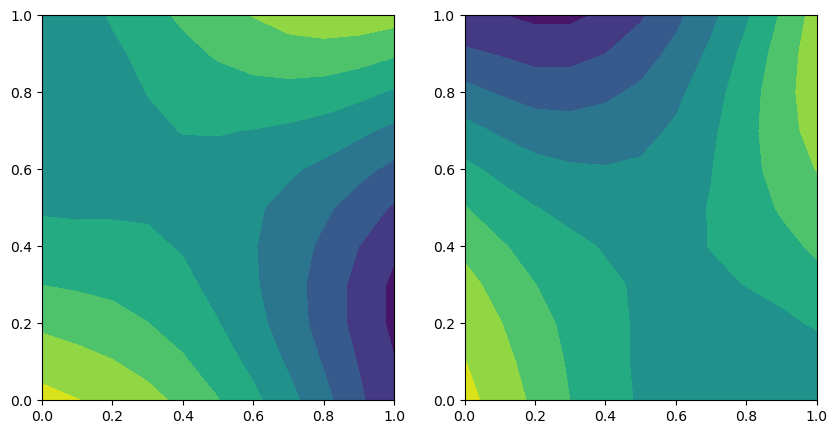

In [15]:
# Plot
[Xt,Yt] = np.meshgrid(X[:,0].unique().numpy(),X[:,1].unique().numpy())
%matplotlib inline
#f, ((y1_ax, y2_ax), (y3_ax, y4_ax), (y5_ax, y6_ax)) = plt.subplots(3, 2, figsize=(40, 60))
f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(10, 5))
cell = 4
drug = 6
task = (cell*2*N_D) + drug
print(task)
task_reflected = task + N_D
print(task_reflected)
y1_ax.contourf(Xt,Yt,mean[:,task].reshape(Xt.shape).detach().numpy(),cmap='viridis')
y2_ax.contourf(Xt,Yt,mean[:,task_reflected].reshape(Xt.shape).detach().numpy(),cmap='viridis')
#task = 1
#task_reflected = task + N_D
#y3_ax.contourf(Xt,Yt,mean[:,task].reshape(Xt.shape).detach().numpy(),cmap='viridis')
#y4_ax.contourf(Xt,Yt,mean[:,task_reflected].reshape(Xt.shape).detach().numpy(),cmap='viridis')
#task = 2
#task_reflected = task + N_D
#y5_ax.contourf(Xt,Yt,mean[:,task].reshape(Xt.shape).detach().numpy(),cmap='viridis')
#y6_ax.contourf(Xt,Yt,mean[:,task_reflected].reshape(Xt.shape).detach().numpy(),cmap='viridis')
None